In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.facecolor'] = "w"


In [3]:
# load opsim database
dbpath_v1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v1_7 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"  # path to all opsim databases


# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
#resultsDb = db.ResultsDb(outDir=outDir)


In [4]:
# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath_v1_5)  # change to opsim database directory
dblist_all_v1_5 = glob.glob('*.db') 
dblist_all_v1_5.sort()

os.chdir(dbpath_v1_7)  # change to opsim database directory
dblist_all_v1_7 = glob.glob('*.db') 
dblist_all_v1_7.sort()

os.chdir(workpath) # change back to work directory


In [8]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [5]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [6]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv'):
    """return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    df_new = df_fom[ ['db', 'prop'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col]) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new

def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [7]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [8]:
def plot_barh_v2(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    # modify labels
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
            tl.set_backgroundcolor("#E5E7E9")
        if 'baseline' in txt:
            tl.set_backgroundcolor("#FF9398")
        #tl.set_text(txt)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
        



In [24]:
df_all = pd.read_csv("./data/df_tgapsFoM_allsky.csv")

if 'db' not in df_all.columns:
    df_all['db'] = dblist_all

df_all.to_csv("./data/df_tgapsFoM_allsky.csv")

In [15]:

df_wfd = pd.read_csv("./data/df_tgapsFoM_wfd.csv")
df_all = pd.read_csv("./data/df_tgapsFoM_allsky.csv")

if 'db' not in df_all.columns:
    df_all['db'] = dblist_all

df_wfd['prop'] = 'wfd'
df_all['prop'] = 'all'

df_wfd = df_wfd.set_index('db')
df_all = df_all.set_index('db')


df = pd.concat([df_wfd, df_all])

df = df.reset_index()

In [16]:
df

db             uu            ug  \
0                         agnddf_v1.5_10yrs.db   10773.203215   8211.584577   
1                       alt_dust_v1.5_10yrs.db   12341.104839  10034.017207   
2    alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db   12946.487613  12122.253436   
3                baseline_2snaps_v1.5_10yrs.db   12316.289497   7215.969192   
4              baseline_samefilt_v1.5_10yrs.db   24512.619412    877.481570   
5                       baseline_v1.5_10yrs.db   11160.552213   8527.314295   
6                      bulges_bs_v1.5_10yrs.db    8925.009590   6712.092150   
7               bulges_bulge_wfd_v1.5_10yrs.db   11272.932227   6442.925598   
8              bulges_cadence_bs_v1.5_10yrs.db   11484.494878   6685.031192   
9       bulges_cadence_bulge_wfd_v1.5_10yrs.db   11109.606995   6656.696114   
10        bulges_cadence_i_heavy_v1.5_10yrs.db    8779.600298   6487.291160   
11                bulges_i_heavy_v1.5_10yrs.db   11223.122785   6374.471271   
12                     daily_ddf_v1.5_10yrs.db   12725.501865   7797.939774   
13                  dcr_nham1_ug_v1.5_10yrs.db   19416.815252   5367.111197   
14                 dcr_nham1_ugr_v1.5_10yrs.db   23871.873039   6273.593820   
15                dcr_nham1_ugri_v1.5_10yrs.db   18616.347606   5779.363239   
16                  dcr_nham2_ug_v1.5_10yrs.db   23475.970517   2994.220542   
17                 dcr_nham2_ugr_v1.5_10yrs.db   21600.576512   4649.257403   
18                dcr_nham2_ugri_v1.5_10yrs.db   22116.567993   4325.874556   
19                       descddf_v1.5_10yrs.db   13838.409596   8357.268020   
20              filterdist_indx1_v1.5_10yrs.db   42832.905435  33169.911168   
21              filterdist_indx2_v1.5_10yrs.db   16568.298503   9826.187449   
22              filterdist_indx3_v1.5_10yrs.db   10533.166115  13955.621185   
23              filterdist_indx4_v1.5_10yrs.db   43919.084061  18392.000512   
24              filterdist_indx5_v1.5_10yrs.db   12314.549068   7617.379149   
25              filterdist_indx6_v1.5_10yrs.db   10909.549307  10490.399850   
26              filterdist_indx7_v1.5_10yrs.db   20144.892756  17363.922077   
27              filterdist_indx8_v1.5_10yrs.db   14785.867153   8554.870141   
28       footprint_add_mag_cloudsv1.5_10yrs.db   13580.790008   7931.035919   
29         footprint_big_sky_dustv1.5_10yrs.db   13219.452164   8036.000837   
..                                         ...            ...           ...   
142          short_exp_5ns_5expt_v1.5_10yrs.db  111881.544232  33580.842147   
143                      spiders_v1.5_10yrs.db   18296.978588  21206.304779   
144               third_obs_pt120v1.5_10yrs.db   18005.950471  24616.082937   
145                third_obs_pt15v1.5_10yrs.db   18572.277451  20610.844876   
146                third_obs_pt30v1.5_10yrs.db   23532.682191  20503.222990   
147                third_obs_pt45v1.5_10yrs.db   17935.788978  21587.417729   
148                third_obs_pt60v1.5_10yrs.db   24394.359381  21326.446924   
149                third_obs_pt90v1.5_10yrs.db   24198.021416  24076.953840   
150            twilight_neo_mod1_v1.5_10yrs.db   23038.242331  27180.627787   
151            twilight_neo_mod2_v1.5_10yrs.db   27264.775147  26250.536040   
152            twilight_neo_mod3_v1.5_10yrs.db   25819.741659  23823.442439   
153            twilight_neo_mod4_v1.5_10yrs.db   25922.607025  23981.791672   
154                          u60_v1.5_10yrs.db    7776.595121  11238.146963   
155                     var_expt_v1.5_10yrs.db   38149.262797  20254.410609   
156    wfd_depth_scale0.65_noddf_v1.5_10yrs.db   19121.702294   9422.584687   
157          wfd_depth_scale0.65_v1.5_10yrs.db   25943.281772  18472.120140   
158    wfd_depth_scale0.70_noddf_v1.5_10yrs.db   18241.739919   9928.736921   
159          wfd_depth_scale0.70_v1.5_10yrs.db   25118.636180  19353.422431   
160    wfd_depth_scale0.75_noddf_v1.5_10yrs.db   17772.837581   9929.162256   
161          wf

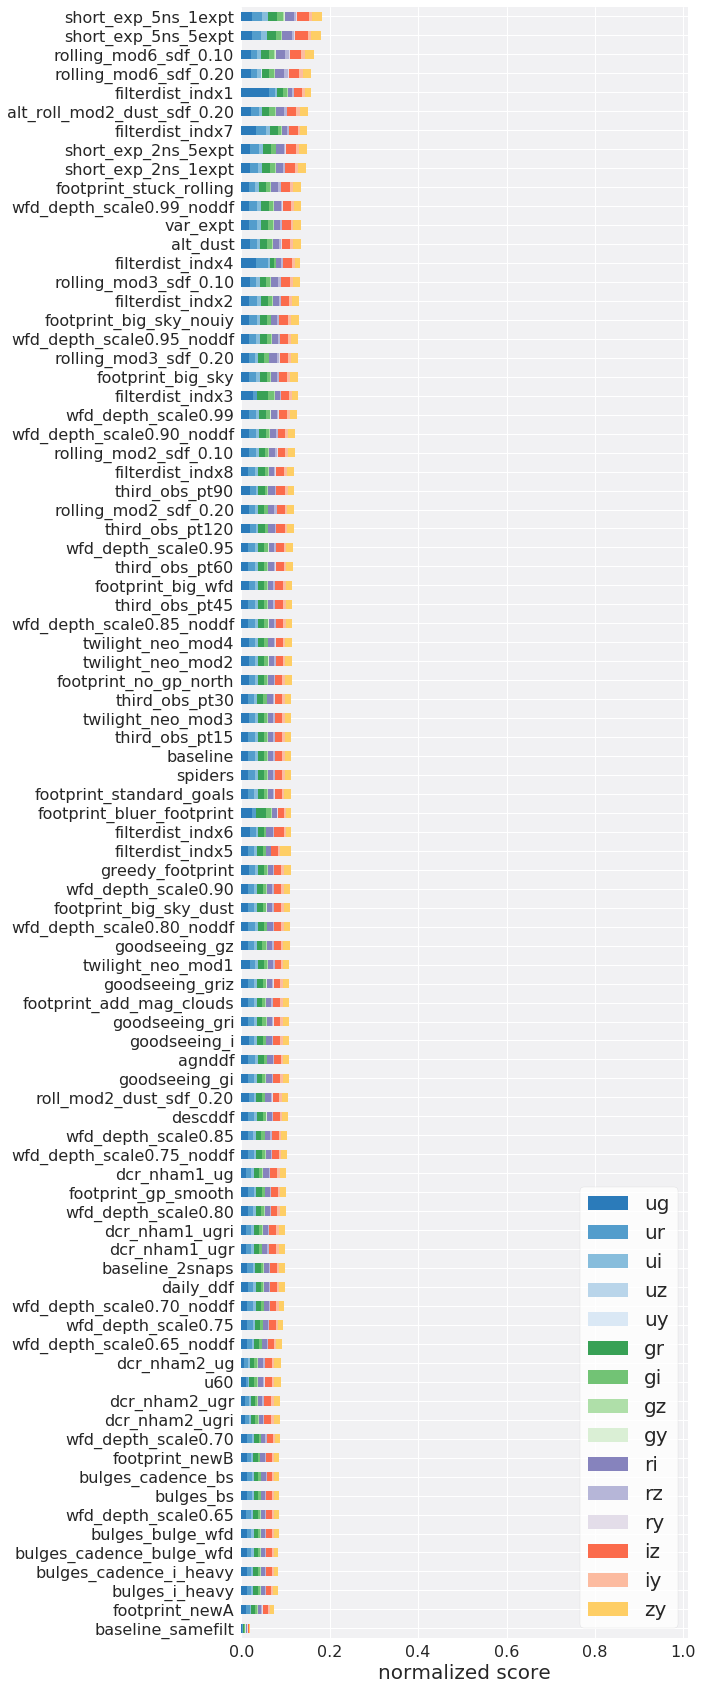

In [22]:
df_norm = get_df_norm(df=df, cols=cols_all)

plot_barh(df_norm[df_norm.prop=='wfd'], colon=cols_diff, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )




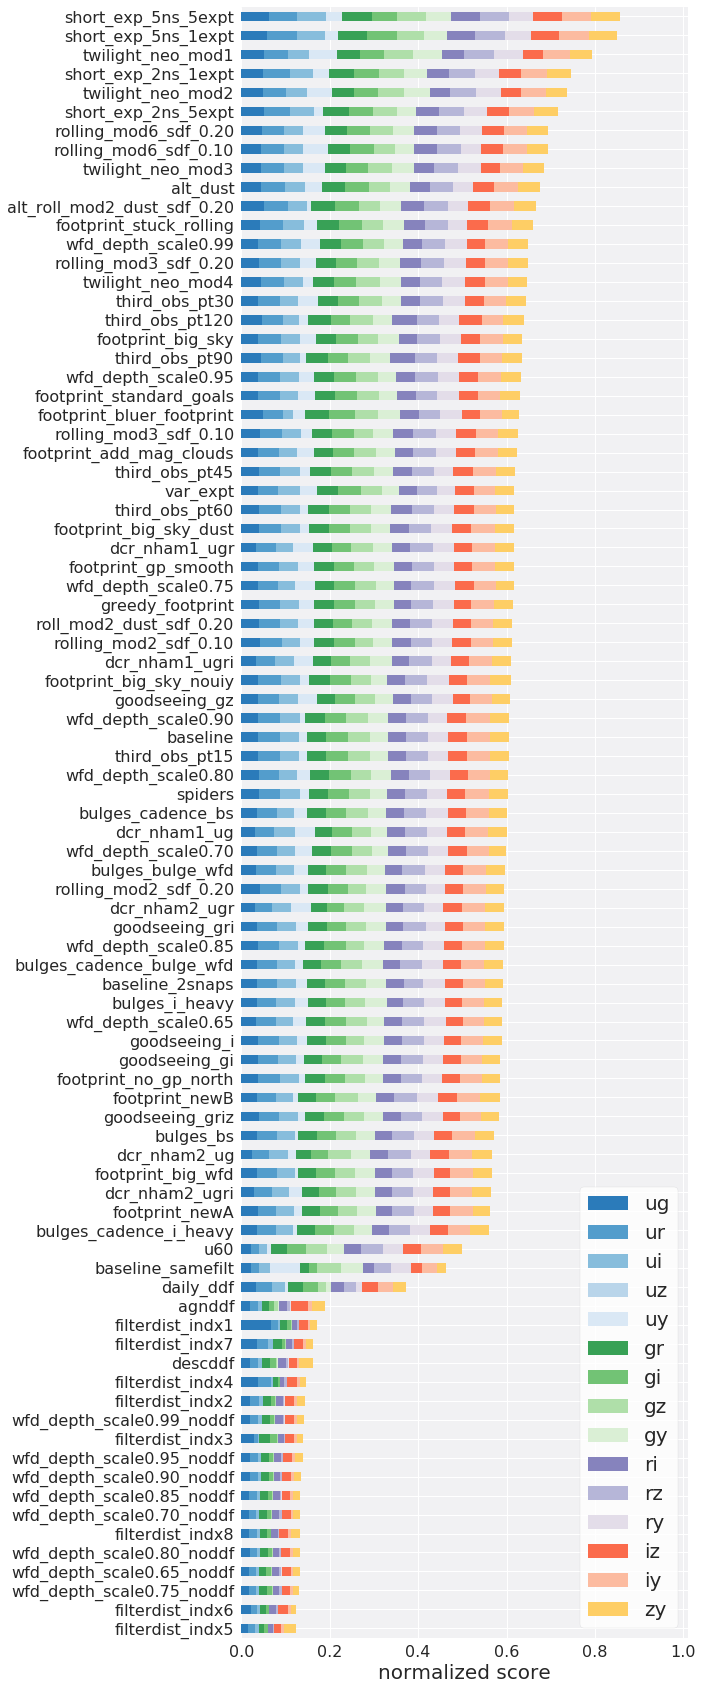

In [23]:
df_norm = get_df_norm(df=df, cols=cols_all)

plot_barh(df_norm[df_norm.prop=='all'], colon=cols_diff, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )


In [ ]:
plot_barh(df_norm[df_norm.prop=='wfd'], colon=cols_all, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )


### compare v1.5 , 1.7

In [10]:
#df_v1_5 = pd.read_csv("../../LSSTunknowns/tdAnom/data_v1_5/df_tgapsFoM_wfd_2d.csv")
#df_v1_5 = pd.read_csv("./data_v1_5/df_Nfields_wfd_2d.csv" )

#df_v1_5 = pd.read_csv("./data_v1_5/df_Nfields_fltNv_wfd.csv" )

df_v1_5 = pd.read_csv("./data_v1_5/df_Nfields_wfd_2d_nothrs.csv" )


df_v1_5['db'] = dblist_all_v1_5
df_v1_5['version'] = 'v1_5'


#df_v1_7 = pd.read_csv("./data_v1_7/df_Nfields_wfd_2d.csv")
#df_v1_7 = pd.read_csv("./data_v1_7/df_tgapsFoM_wfd_2d.csv" )
#df_v1_7 = pd.read_csv("./data_v1_7/df_Nfields_fltNv_wfd.csv")

df_v1_7 = pd.read_csv("./data_v1_7/df_Nfields_wfd_2d_nothrs.csv" )
df_v1_7['db'] = dblist_all_v1_7
df_v1_7['version'] = 'v1_7'

df = pd.concat([df_v1_5, df_v1_7])

df = df.reset_index()


In [10]:
flts = ['u', 'g', 'r', 'i', 'z', 'y']


In [11]:
cols_same

['uu', 'gg', 'rr', 'ii', 'zz', 'yy']

In [13]:

df_norm = df[ ['db', 'version'] ].copy()
for col in cols_all:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_norm[col] = scale(df[col]) 
    
df_norm['family'] = df_norm.apply(get_family, axis=1)
  

In [20]:
df

index                                         db    uu    ug    ur    ui  \
0        0                       agnddf_v1.5_10yrs.db  1458  1457  1457  1433   
1        1                     alt_dust_v1.5_10yrs.db  1471  1472  1462  1436   
2        2  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db  1471  1475  1468  1443   
3        3              baseline_2snaps_v1.5_10yrs.db  1458  1458  1456  1427   
4        4            baseline_samefilt_v1.5_10yrs.db  1455  1378  1392  1379   
5        5                     baseline_v1.5_10yrs.db  1458  1458  1456  1435   
6        6                    bulges_bs_v1.5_10yrs.db  1453  1454  1452  1385   
7        7             bulges_bulge_wfd_v1.5_10yrs.db  1458  1459  1454  1389   
8        8            bulges_cadence_bs_v1.5_10yrs.db  1451  1456  1452  1378   
9        9     bulges_cadence_bulge_wfd_v1.5_10yrs.db  1453  1457  1450  1391   
10      10       bulges_cadence_i_heavy_v1.5_10yrs.db  1451  1451  1450  1384   
11      11               bulges_i_heavy_v1.5_10yrs.db  1453  1454  1452  1388   
12      12                    daily_ddf_v1.5_10yrs.db  1458  1459  1457  1425   
13      13                 dcr_nham1_ug_v1.5_10yrs.db  1457  1456  1456  1438   
14      14                dcr_nham1_ugr_v1.5_10yrs.db  1458  1458  1457  1425   
15      15               dcr_nham1_ugri_v1.5_10yrs.db  1455  1456  1454  1433   
16      16                 dcr_nham2_ug_v1.5_10yrs.db  1455  1449  1456  1427   
17      17                dcr_nham2_ugr_v1.5_10yrs.db  1456  1455  1455  1427   
18      18               dcr_nham2_ugri_v1.5_10yrs.db  1458  1457  1456  1421   
19      19                      descddf_v1.5_10yrs.db  1458  1460  1457  1436   
20      20             filterdist_indx1_v1.5_10yrs.db  1460  1461  1458  1428   
21      21             filterdist_indx2_v1.5_10yrs.db  1460  1461  1460  1441   
22      22             filterdist_indx3_v1.5_10yrs.db  1459  1462  1444  1415   
23      23             filterdist_indx4_v1.5_10yrs.db  1462  1459  1463  1437   
24      24             filterdist_indx5_v1.5_10yrs.db  1458  1461  1461  1436   
25      25             filterdist_indx6_v1.5_10yrs.db  1462  1462  1455  1438   
26      26             filterdist_indx7_v1.5_10yrs.db  1461  1462  1459  1442   
27      27             filterdist_indx8_v1.5_10yrs.db  1458  1459  1459  1434   
28      28      footprint_add_mag_cloudsv1.5_10yrs.db  1454  1456  1457  1435   
29      29        footprint_big_sky_dustv1.5_10yrs.db  1469  1469  1470  1441   
..     ...                                        ...   ...   ...   ...   ...   
130     44  rolling_nm_scale0.9_nslice3_v1.7_10yrs.db  1455  1456  1453  1432   
131     45  rolling_nm_scale1.0_nslice2_v1.7_10yrs.db  1456  1457  1455  1433   
132     46  rolling_nm_scale1.0_nslice3_v1.7_10yrs.db  1460  1461  1454  1430   
133     47     rolling_scale0.2_nslice2_v1.7_10yrs.db  1457  1457  1458  1432   
134     48     rolling_scale0.2_nslice3_v1.7_10yrs.db  1456  1456  1455  1436   
135     49     rolling_scale0.4_nslice2_v1.7_10yrs.db  1455  1458  1456  1436   
136     50     rolling_scale0.4_nslice3_v1.7_10yrs.db  1457  1455  1455  1432   
137     51     rolling_scale0.6_nslice2_v1.7_10yrs.db  1456  1458  1457  1436   
138     52     rolling_scale0.6_nslice3_v1.7_10yrs.db  1455  1457  1456  1437   
139     53     rolling_scale0.8_nslice2_v1.7_10yrs.db  1457  1457  1455  1436   
140     54     rolling_scale0.8_nslice3_v1.7_10yrs.db  1455  1455  1455  1437   
141     55     rolling_scale0.9_nslice2_v1.7_10yrs.db  1458  1459  1457  1430   
142     56     rolling_scale0.9_nslice3_v1.7_10yrs.db  1454  1457  1454  1433   
143     57     rolling_scale1.0_nslice2_v1.7_10yrs.db  1454  1457  1454  1430   
144     58     rolling_scale1.0_nslice3_v1.7_10yrs.db  1457  1460  1455  1435   
145     59             twi_neo_pattern1_v1.7_10yrs.db  1456  1458  1456  1427   
146     60             twi_neo_pattern2_v1.7_10yrs.db  1456  1456  1457  1418   
147     61             twi_neo_patte

In [19]:
df_norm.min(axis=0)

db         agnddf_v1.5_10yrs.db
version                    v1_5
uu                     0.718733
ug                     0.718886
ur                     0.716703
ui                     0.711827
uz                     0.372893
uy                      0.17026
gg                     0.764063
gr                     0.764866
gi                     0.754135
gz                      0.69783
gy                     0.614558
rr                     0.766213
ri                     0.764449
rz                     0.751789
ry                     0.696231
ii                      0.76663
iz                     0.764995
iy                     0.712013
zz                     0.765123
zy                     0.719346
yy                     0.720588
family                   agnddf
dtype: object

In [17]:
df_norm.columns

Index(['db', 'version', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi',
       'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy',
       'family'],
      dtype='object')

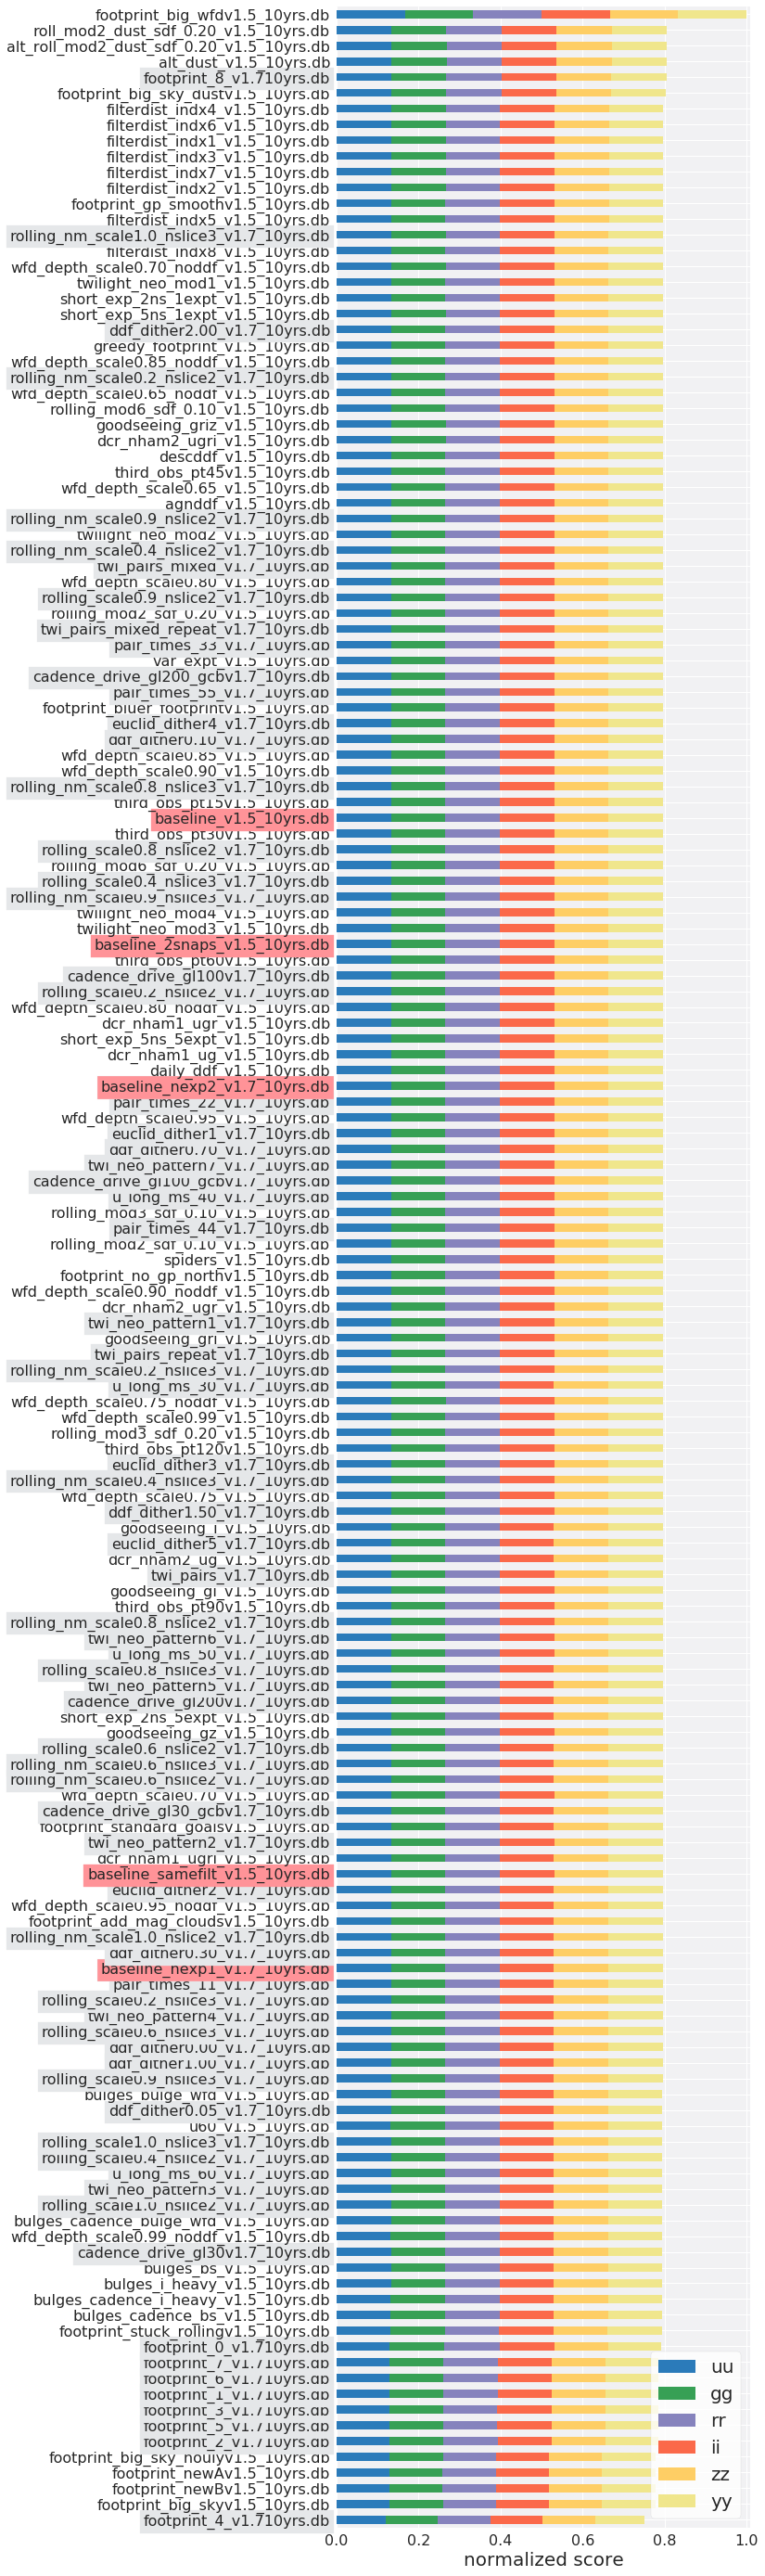

In [22]:
plot_barh_v2(df_norm, colon=cols_same, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )

#plt.xlim([0.6, 1])


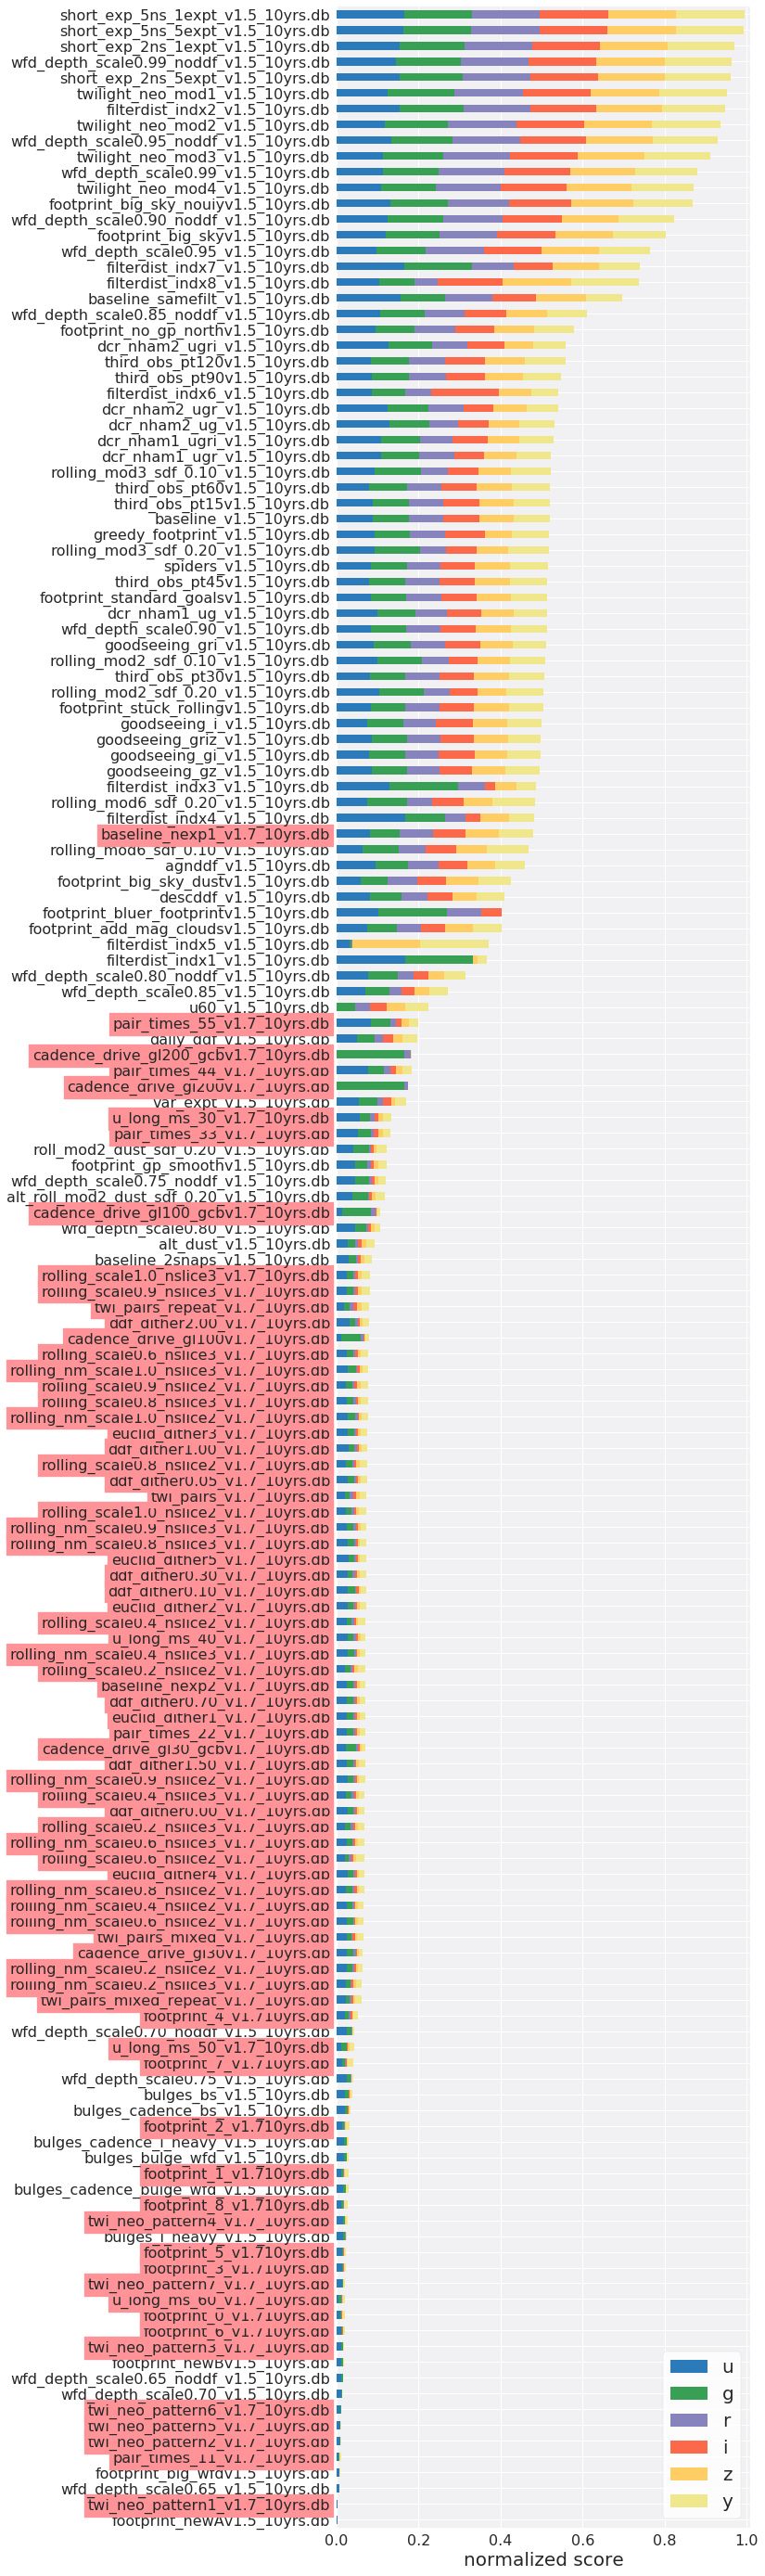

In [49]:
plot_barh_v2(df_norm, colon=flts, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )



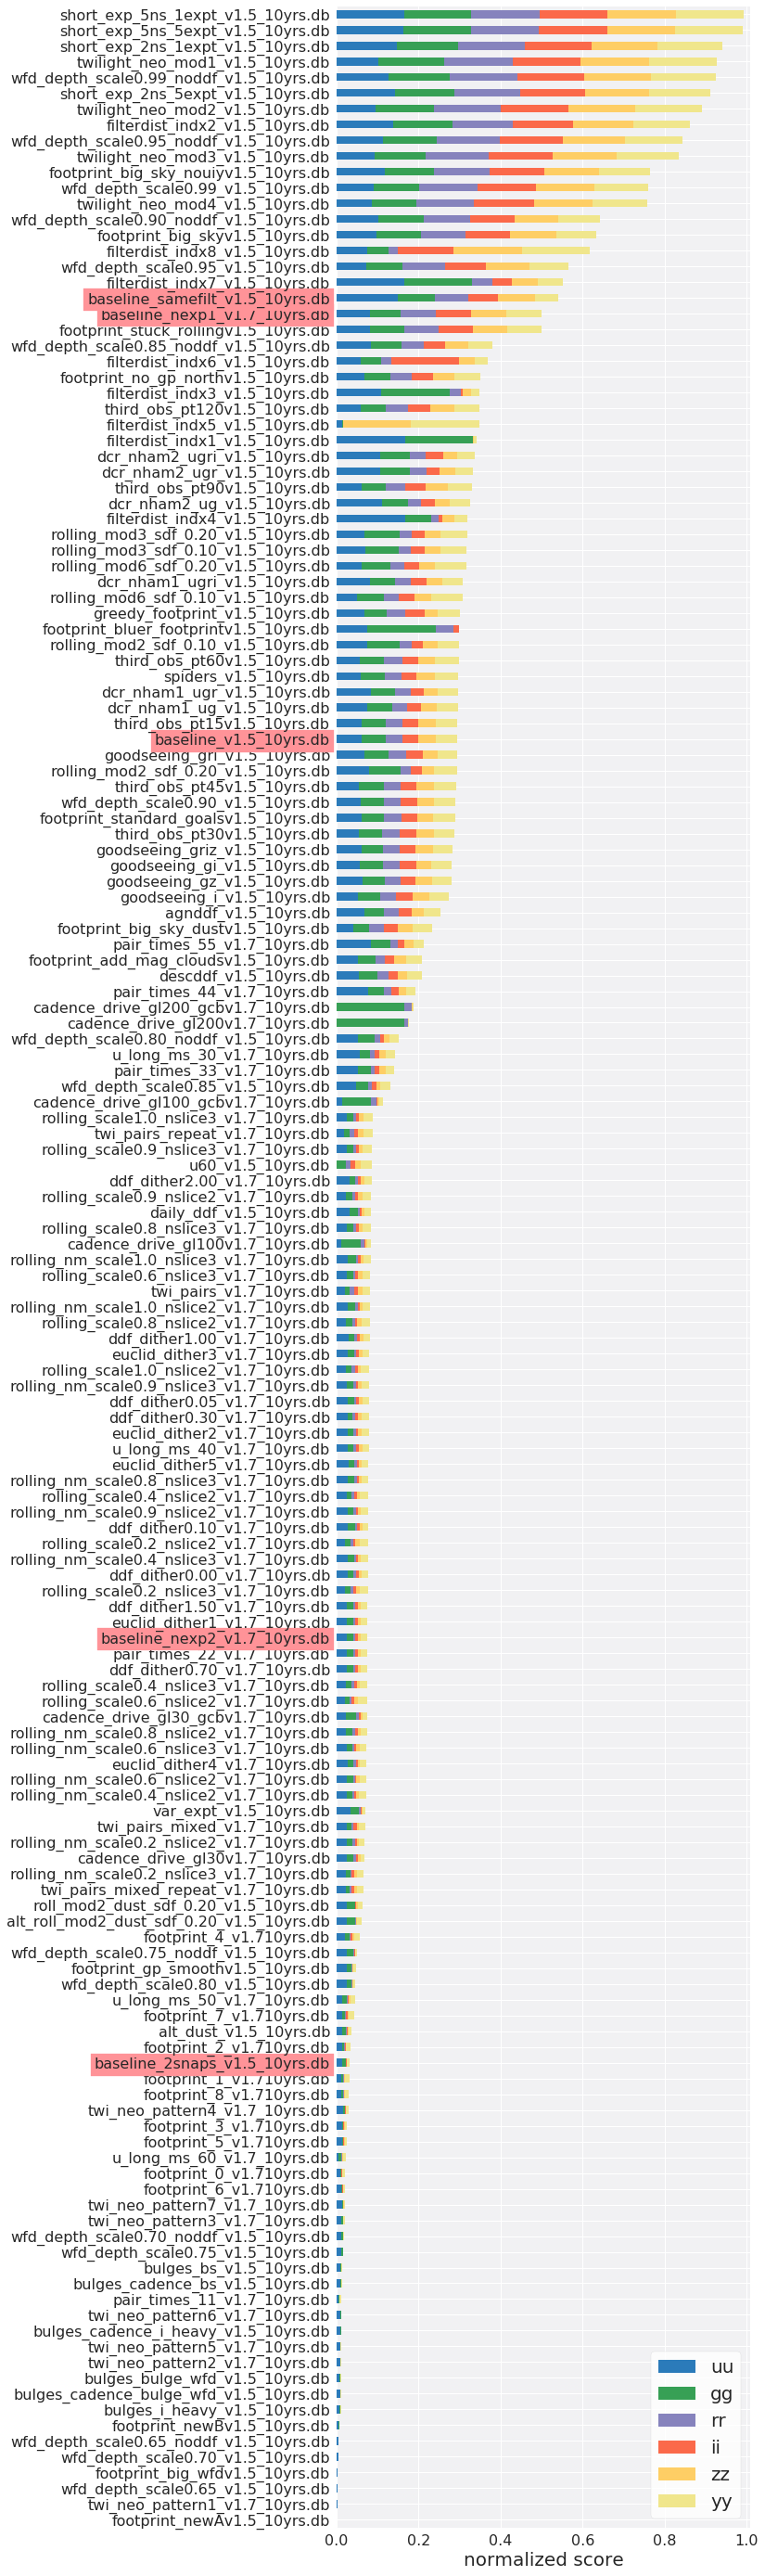

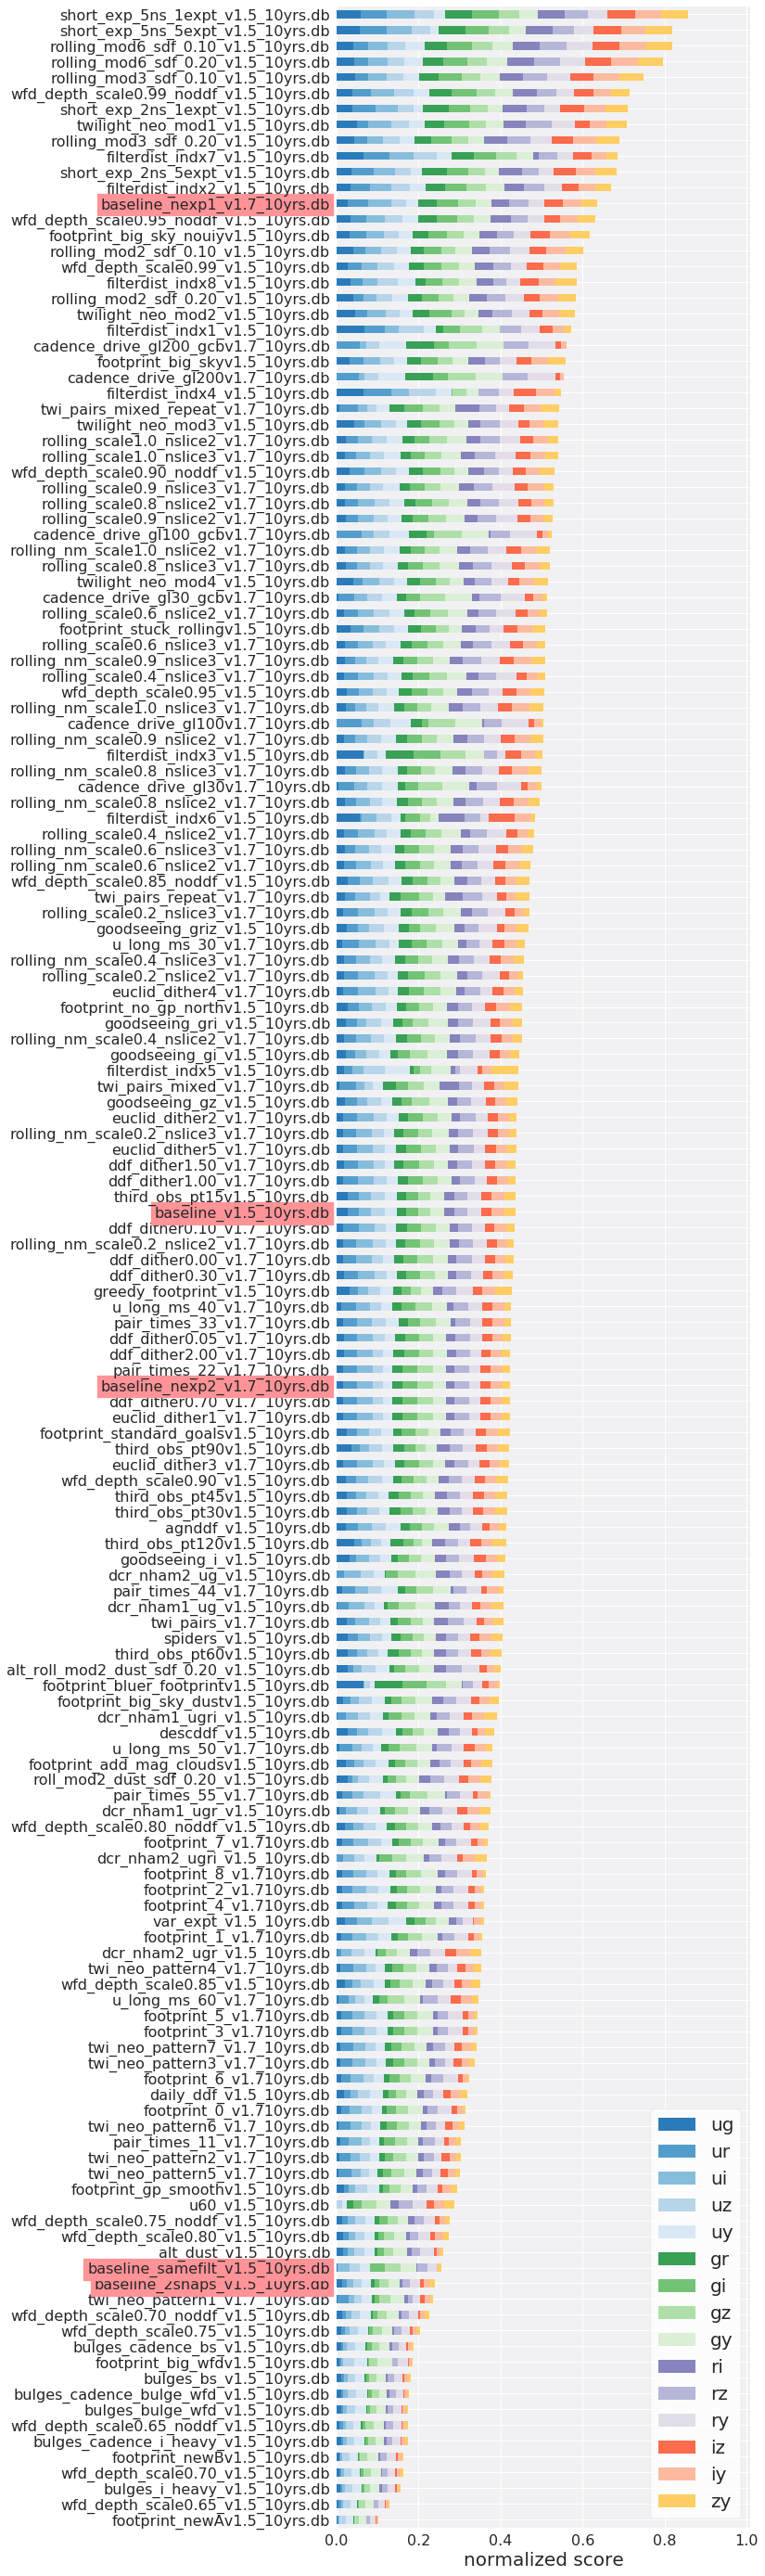

In [23]:
plot_barh_v2(df_norm, colon=cols_same, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )
plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='diff') )




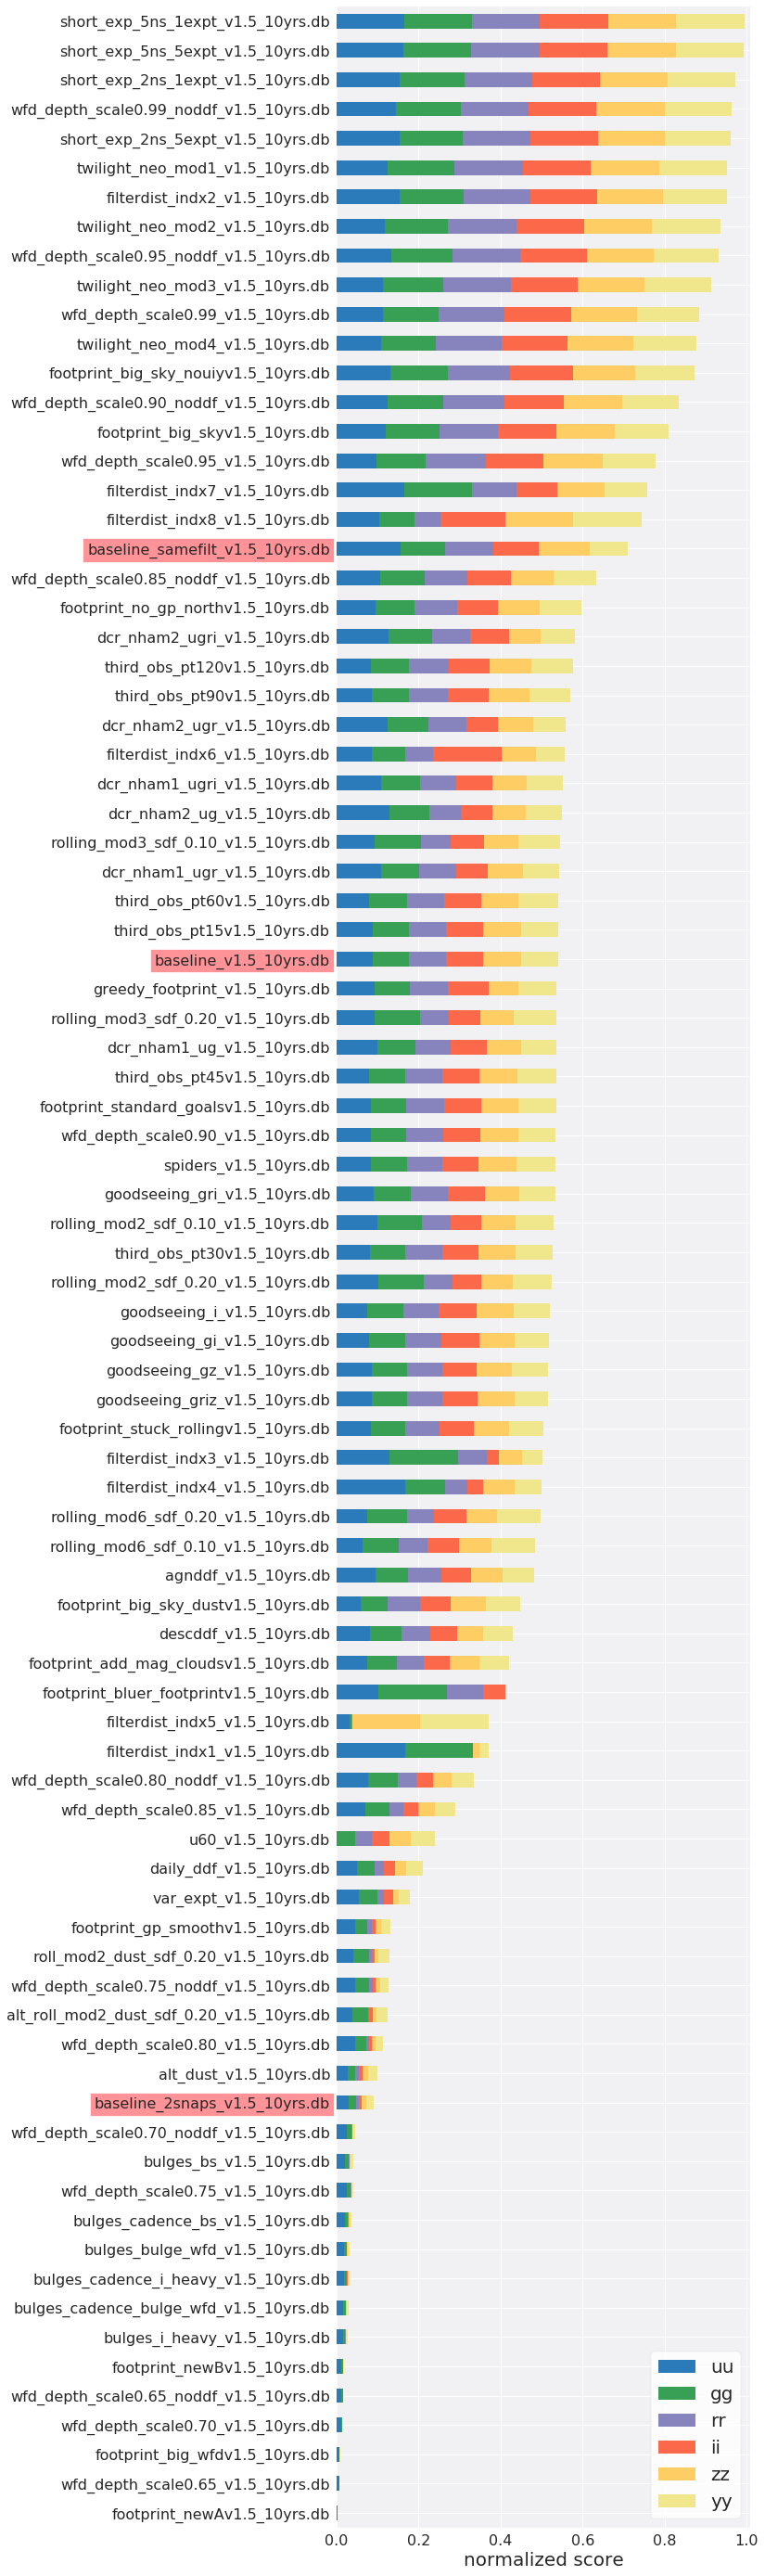

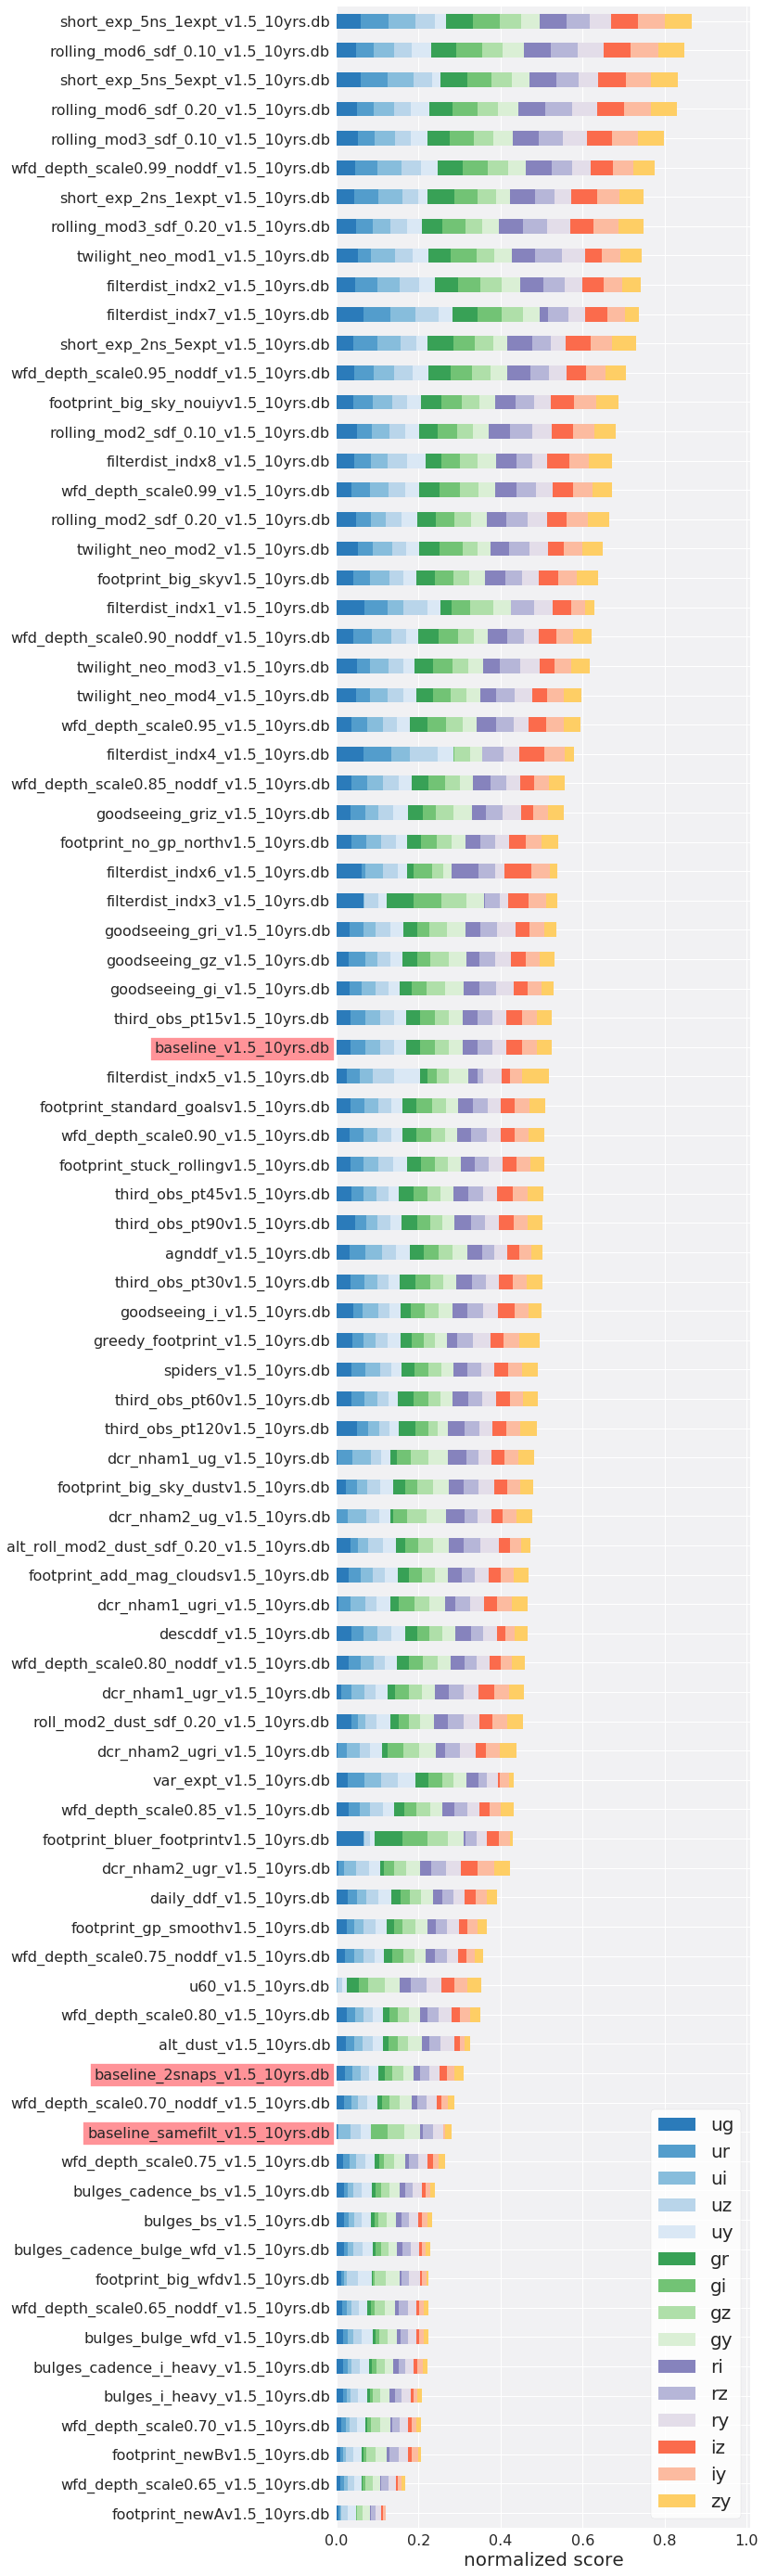

In [16]:
idx = df_norm.version=='v1_5'
plot_barh_v2(df_norm[idx], colon=cols_same, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )
plot_barh_v2(df_norm[idx], colon=cols_diff, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='diff') )





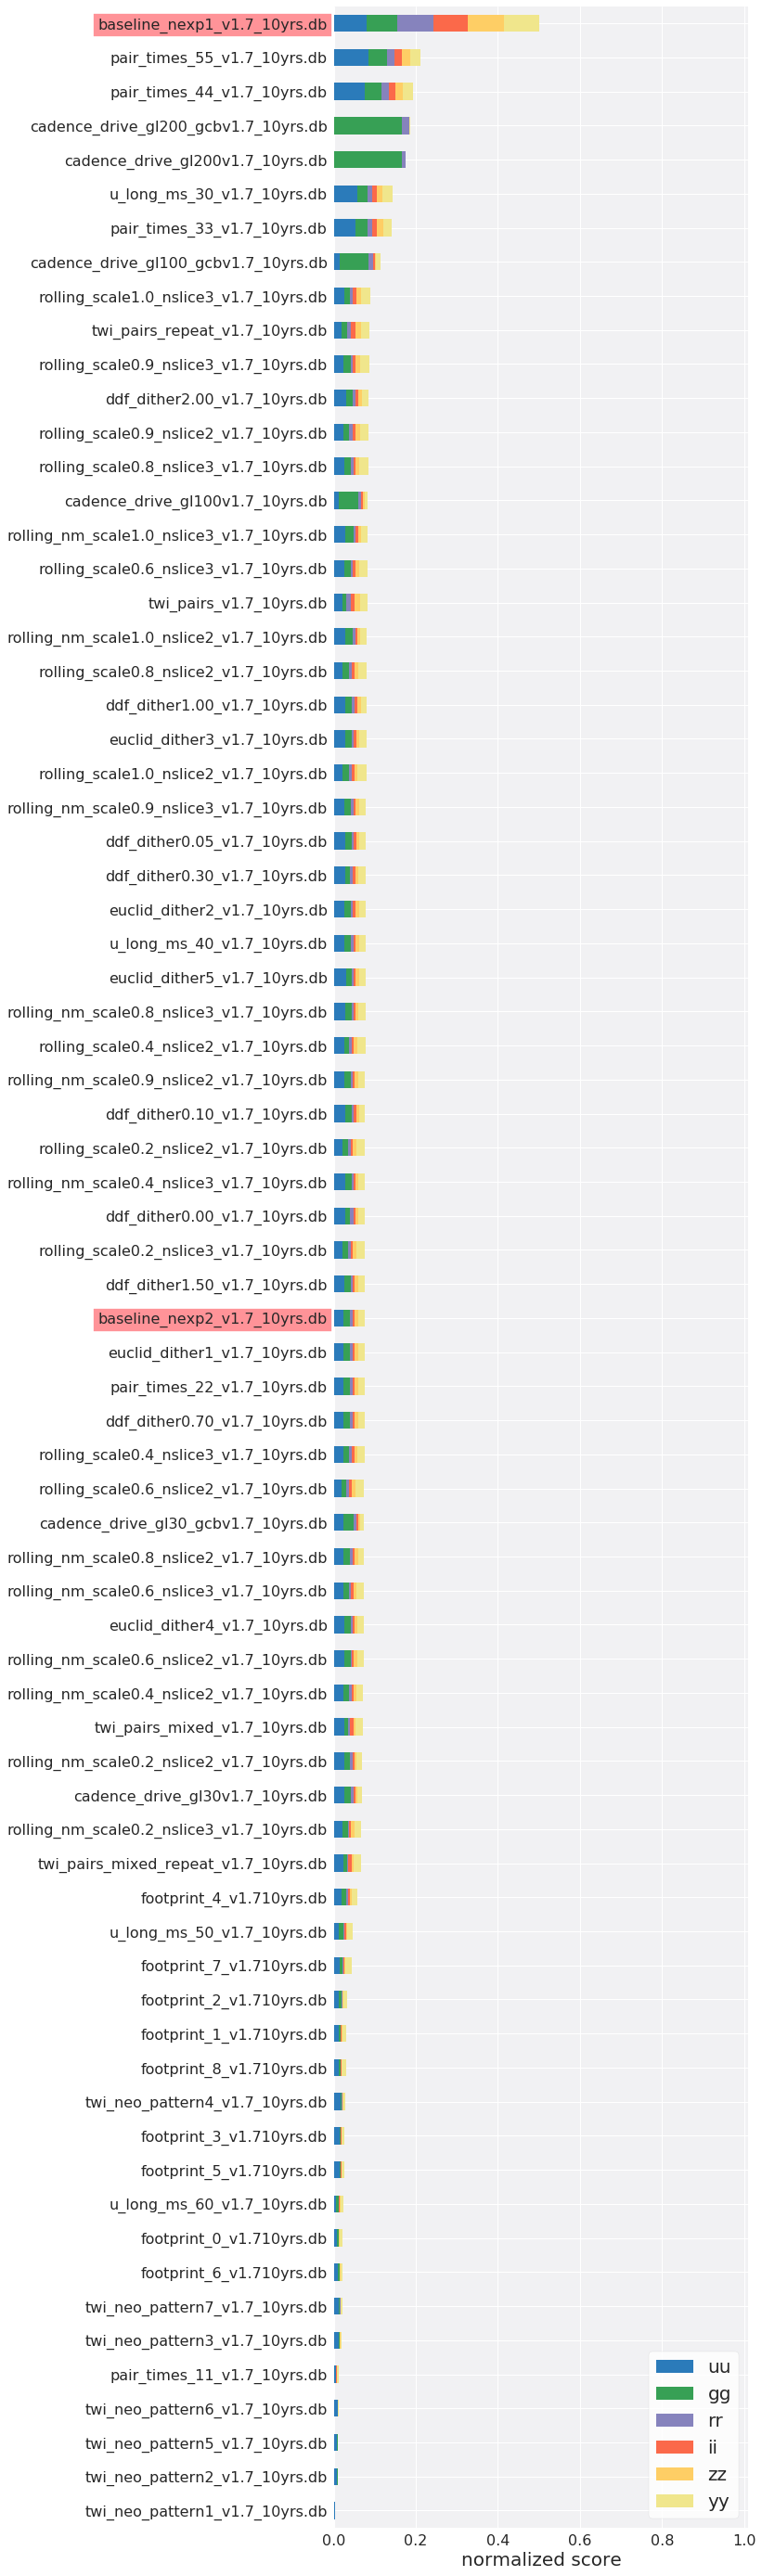

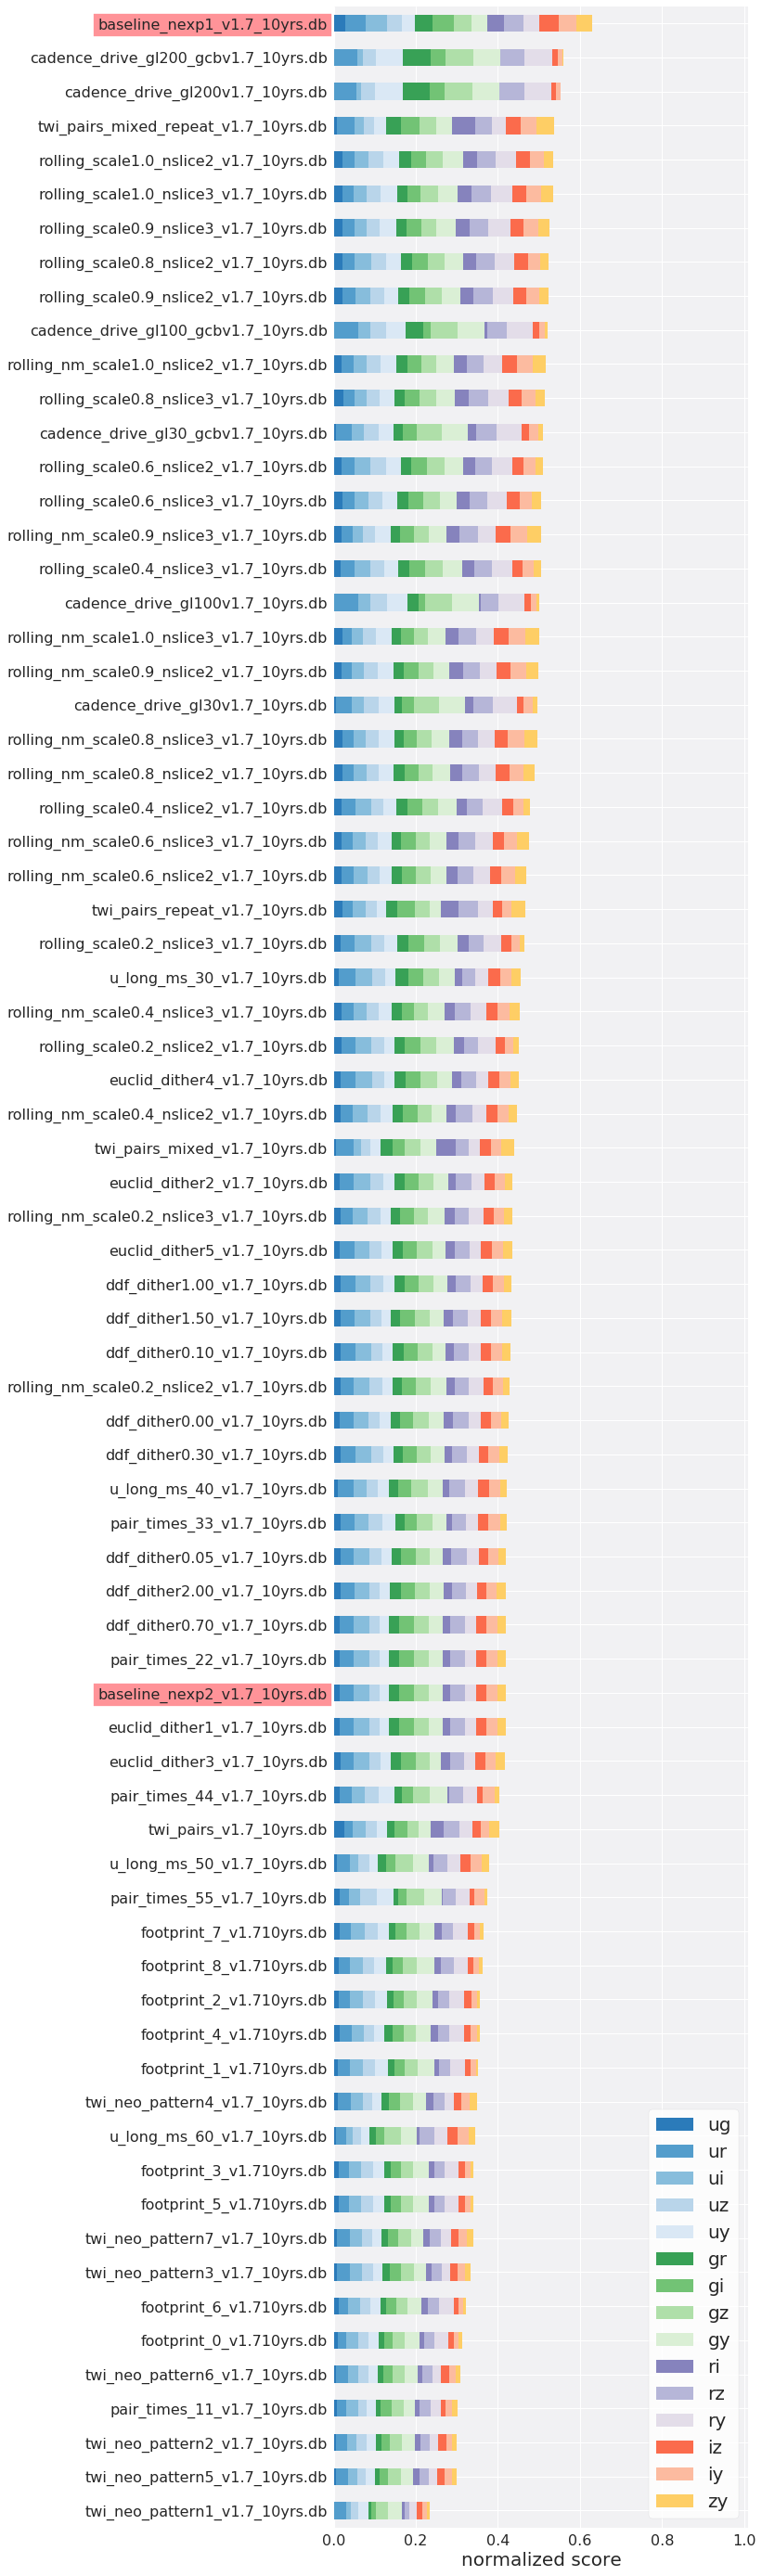

In [17]:
idx = df_norm.version=='v1_7'
plot_barh_v2(df_norm[idx], colon=cols_same, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )
plot_barh_v2(df_norm[idx], colon=cols_diff, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='diff') )




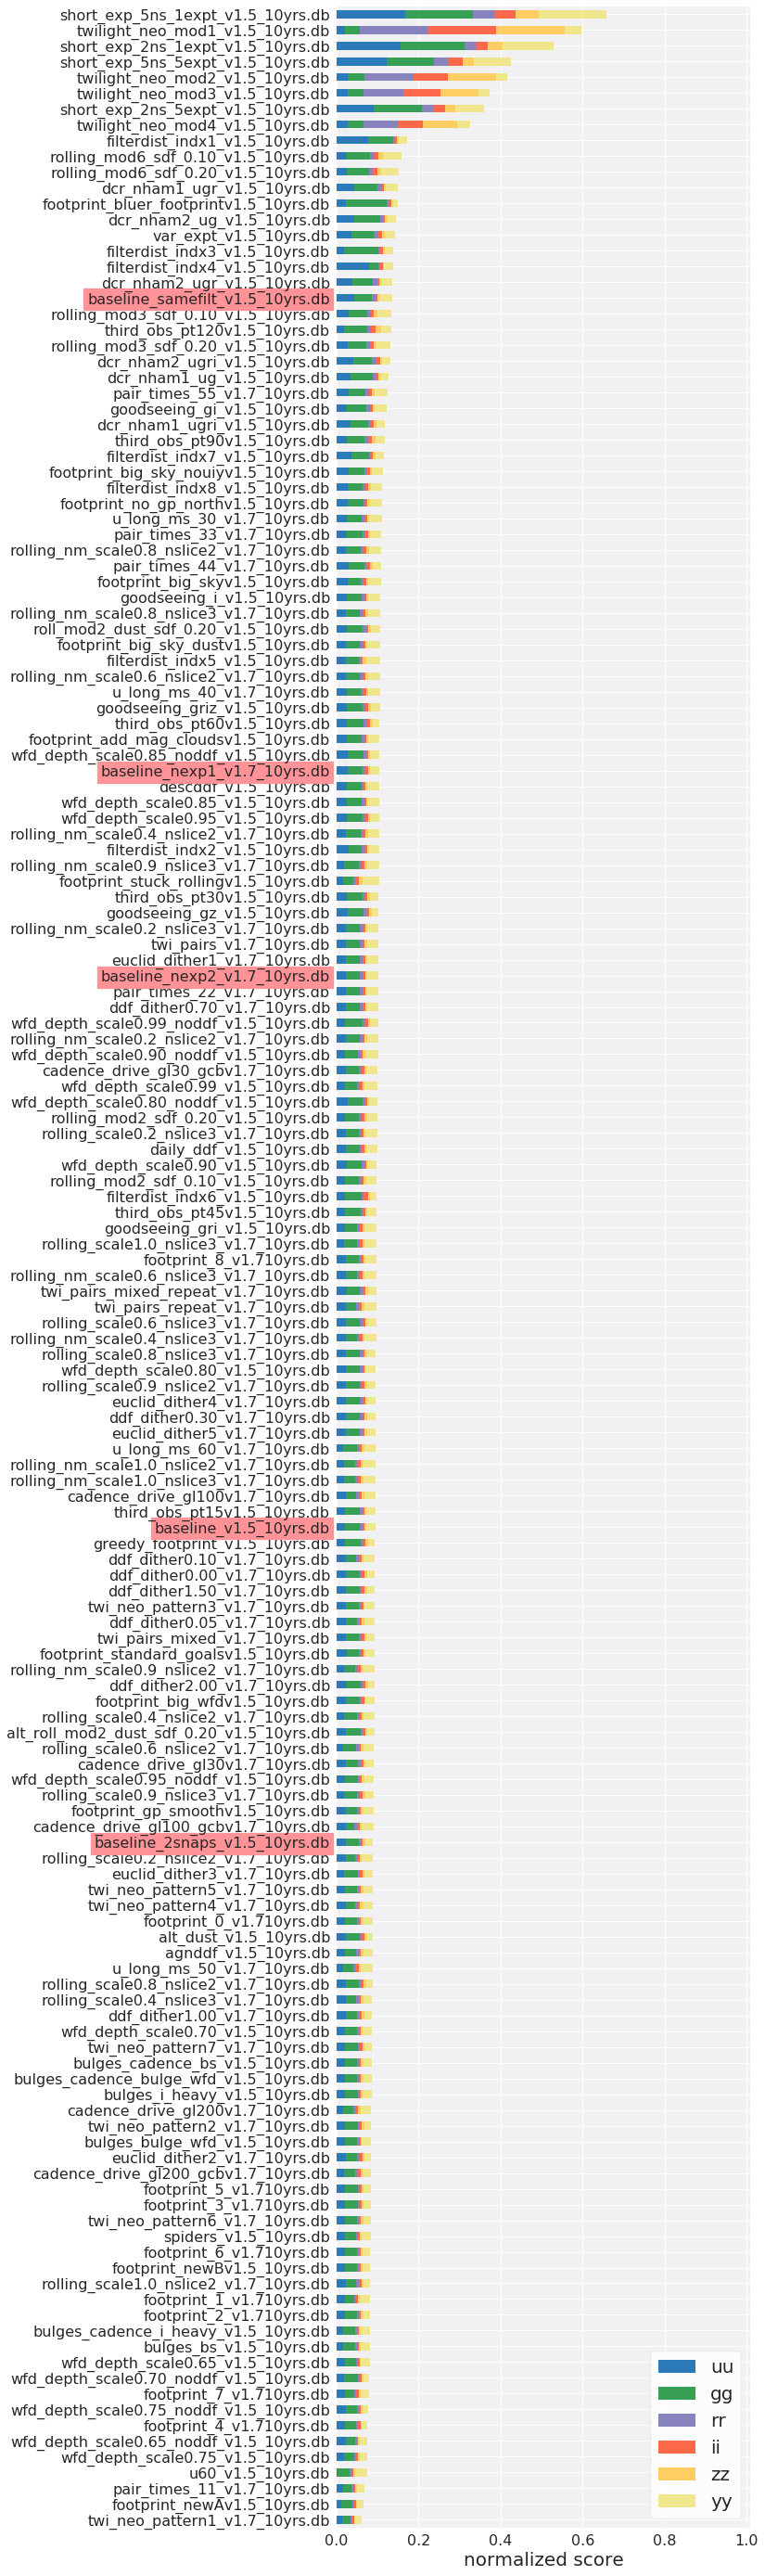

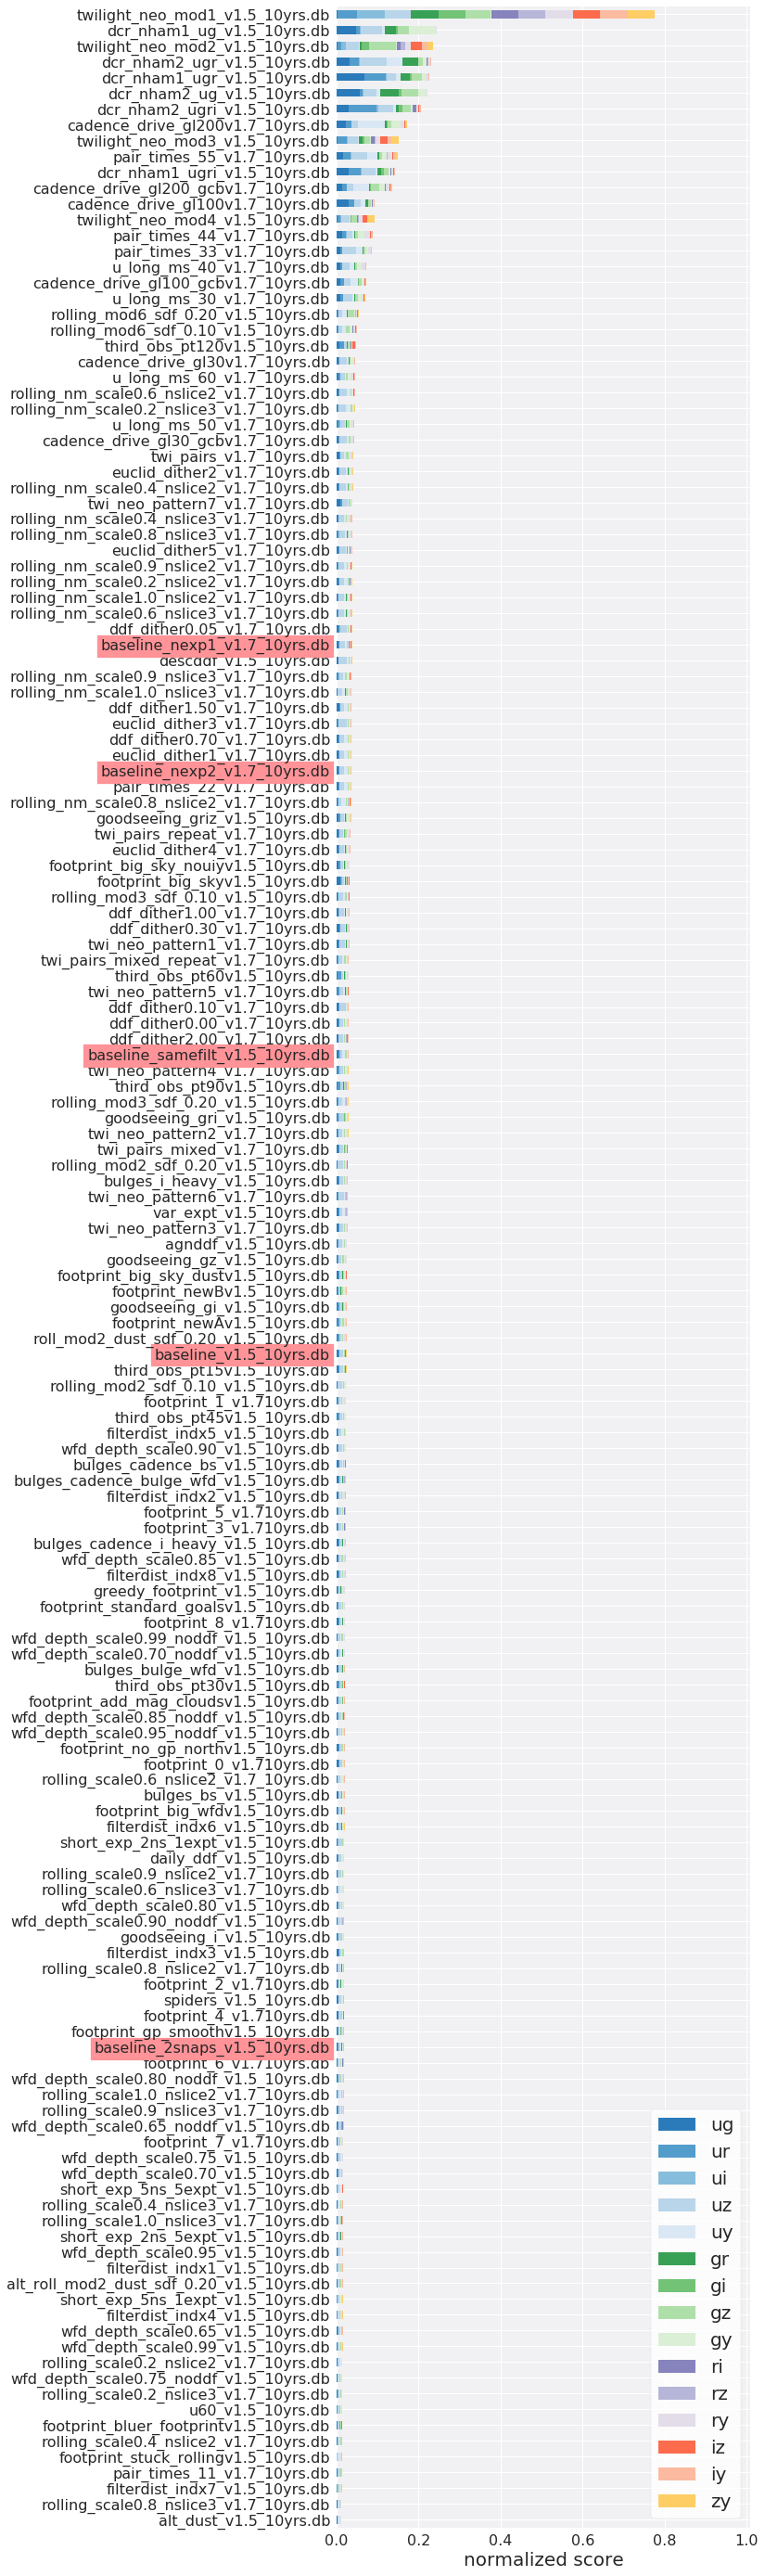

In [20]:
# tgaps 2d
plot_barh_v2(df_norm, colon=cols_same, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='same') )
plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, figsize=(8, 50), savefig=None, cmap=get_mycmap(pairs='diff') )

